In [1]:
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [2]:
path = "cycle"
annotation = "cycle_annot"

c1.jpg


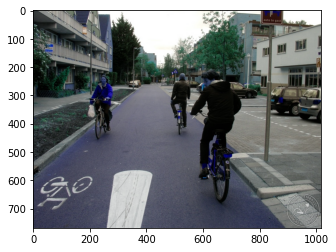

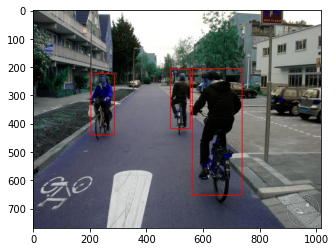

In [3]:
for e,i in enumerate(os.listdir(annotation)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annotation,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [4]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

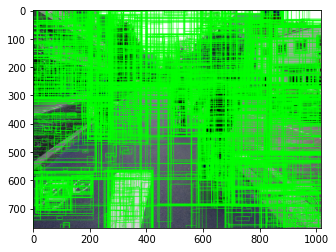

In [5]:
im = cv2.imread(os.path.join(path,"c1.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#    print(x,y,w,h)
#    imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [6]:
train_images=[]
train_labels=[]

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [9]:
for e,i in enumerate(os.listdir(annotation)):
    try:
        if i.startswith("c"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annotation,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 c1.jpg
1 c2.jpg
2 c3.jpg
3 c4.jpg
4 c5.jpg
5 c6.jpg
6 c7.jpg


In [10]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [11]:
X_new.shape

(232, 224, 224, 3)

In [12]:
vggmodel = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
weights = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'

vggmodel = VGG16(weights= weights, include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [17]:
X= vggmodel.layers[-2].output

predictions = Dense(2, activation="softmax")(X)

In [20]:
model_final = Model(vggmodel.input, predictions)

In [21]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [22]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [24]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [25]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [26]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [27]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(208, 224, 224, 3) (24, 224, 224, 3) (208, 2) (24, 2)


In [28]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [32]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 5, epochs= 10, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.9306 WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.89821, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 100s 20s/step - loss: 0.2948 - accuracy: 0.9306 - val_loss: 0.8982 - val_accuracy: 0.7917
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9583WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.

Epoch 00002: val_loss improved from 0.89821 to 0.01130, saving model

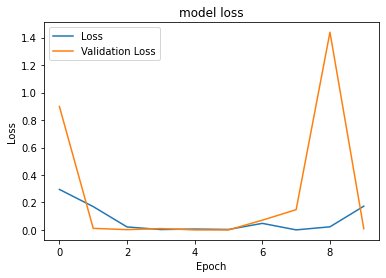

In [33]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
#plt.savefig('chart loss.png')

Cycling


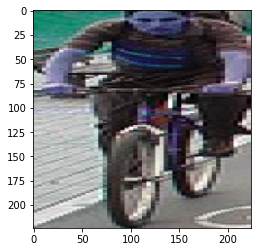

In [43]:
im = X_test[23]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("Cycling")
else:
    print("Not Cycling")

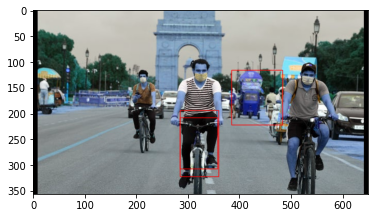

In [47]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 100:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.95:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)